In [20]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd

import geodatasets


In [21]:
data =pd.read_csv(r"C:/Users/thean/Documents/DACS/-ACS/Online Retail Cleaned Data.csv")
print(data.info())
print("-------------------------"*5)
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280452 entries, 0 to 280451
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    280452 non-null  int64  
 1   StockCode    280452 non-null  object 
 2   Description  280452 non-null  object 
 3   Quantity     280452 non-null  int64  
 4   InvoiceDate  280452 non-null  object 
 5   UnitPrice    280452 non-null  float64
 6   CustomerID   280452 non-null  int64  
 7   Country      280452 non-null  object 
 8   TotalPrice   280452 non-null  float64
 9   YearMonth    280452 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 21.4+ MB
None
-----------------------------------------------------------------------------------------------------------------------------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
0,536365,85123A,white hanging heart t-light holder,6,12/1/2010 8:26,2.55,17850,United Kingdom,15.30,2010-12
1,536365,71053,white metal lantern,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34,2010-12
2,536365,84406B,cream cupid hearts coat hanger,8,12/1/2010 8:26,2.75,17850,United Kingdom,22.00,2010-12
3,536365,84029G,knitted union flag hot water bottle,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34,2010-12
4,536365,84029E,red woolly hottie white heart.,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34,2010-12


In [22]:
# Định dạng lại cột thời gian và mã khách hàng
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceNo'] = data['InvoiceNo'].astype(str)
data['CustomerID'] = data['CustomerID'].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280452 entries, 0 to 280451
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    280452 non-null  object        
 1   StockCode    280452 non-null  object        
 2   Description  280452 non-null  object        
 3   Quantity     280452 non-null  int64         
 4   InvoiceDate  280452 non-null  datetime64[ns]
 5   UnitPrice    280452 non-null  float64       
 6   CustomerID   280452 non-null  object        
 7   Country      280452 non-null  object        
 8   TotalPrice   280452 non-null  float64       
 9   YearMonth    280452 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 21.4+ MB


In [23]:
data.Country.value_counts()

Country
United Kingdom          253157
Germany                   6275
France                    5995
EIRE                      4373
Spain                     1681
Belgium                   1395
Switzerland               1183
Portugal                  1054
Norway                     602
Netherlands                498
Italy                      480
Channel Islands            435
Finland                    413
Australia                  374
Cyprus                     372
Austria                    273
Denmark                    232
Poland                     213
Sweden                     201
Unspecified                157
Israel                     153
Iceland                    138
USA                        130
Singapore                  109
Canada                     100
Japan                       93
Greece                      91
Malta                       64
United Arab Emirates        44
European Community          35
RSA                         34
Lithuania                   25


In [24]:
print(data['InvoiceDate'].max())


2011-12-09 12:50:00


Ngày mua hàng gần nhất là 9/12/2011 vậy nên ta sẽ chọn ngày đầu năm 2012 làm mốc để tính cột recency( lần mua hàng gần nhất của khách hàng)

In [25]:
#tính rencencyrencency
date = '2012-01-01'
date = pd.to_datetime(date)

recency=data.groupby(["CustomerID"]).agg({"InvoiceDate": lambda x: ((date - x.max()).days)})
recency

,InvoiceDate
CustomerID,
12347,24
12348,270
12349,40
12350,332
12352,58
...,...
18280,299
18281,202
18282,29


nhóm dữ liệu theo CustomerID lấy thời gian làm mốc trừ cho thời gian mua hàng gần nhất trong cột invoiceDate để tính recency

In [26]:
#tính frequency 
freq = data.drop_duplicates(subset="InvoiceNo").groupby(["CustomerID"])[["InvoiceNo"]].count()
freq.head()

,InvoiceNo
CustomerID,
12347,7
12348,3
12349,1
12350,1
12352,7


loại bỏ các dòng có mã hóa đơn trùng lặp, nhóm dữ liệuliệu theo CustomerID và đếm số hóa đơn khác nhau để tính frequency

In [27]:
#tính monetary
money = data.groupby(["CustomerID"])[["TotalPrice"]].sum()
money.head()

,TotalPrice
CustomerID,
12347,2664.14
12348,90.20
12349,710.20
12350,294.40
12352,711.09


dựa vào cột TotalPrice đã tính trước đó ta tính monetary bằng tính tổng TotalPrice của khách hàng 

In [28]:
recency.columns = ["Recency"]
freq.columns = ["Frequency"]
money.columns = ["Monetary"]
RFM_data = pd.concat([recency, freq, money], axis=1)
print(RFM_data.head())
print("--------"*5)
print(RFM_data.shape)


            Recency  Frequency  Monetary
CustomerID                              
12347            24          7   2664.14
12348           270          3     90.20
12349            40          1    710.20
12350           332          1    294.40
12352            58          7    711.09
----------------------------------------
(4140, 3)


Ta nối các dataframe lại để tạo dataframe tổng hợp chứa các biến độc lập cần để phân cụm trong mô hình RFM 

In [29]:
#Chuẩn hóa dữ liệu chuẩn bị xây dựng mô hình
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(RFM_data)

In [30]:
print(scaled)

[[-0.90333482  0.45049422  1.15172055]
 [ 1.55734036 -0.13743109 -0.42323634]
 [-0.74329091 -0.43139375 -0.04386725]
 ...
 [-0.8533211  -0.28441242 -0.42762356]
 [-0.89333208  1.77332616  0.69846015]
 [-0.50322504 -0.13743109  0.09904475]]


Để tránh việc mô hình bị chi phối bởi các giá trị lớn hơn ảnh hưởng đến độ chính xác ta chuẩn hóa dữ liệu bằng StandardScaler trước khi xây dựng mô hình phân cụm

In [31]:
#chọn số cụm dữ liệu k tối ưu trước khi phân cụm
from sklearn.cluster import KMeans 
inertia = []
for i in np.arange(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

Trước khi xây dựng mô hình phân cụm, tiến hành tìm số cụm k tối ưu bằng phương pháp Elbow
Chỉ số Inertia hay WCSS (tổng bình phương khoảng cách từ các điểm đến tâm cụm) được dùng để đánh giá chất lượng phân cụm

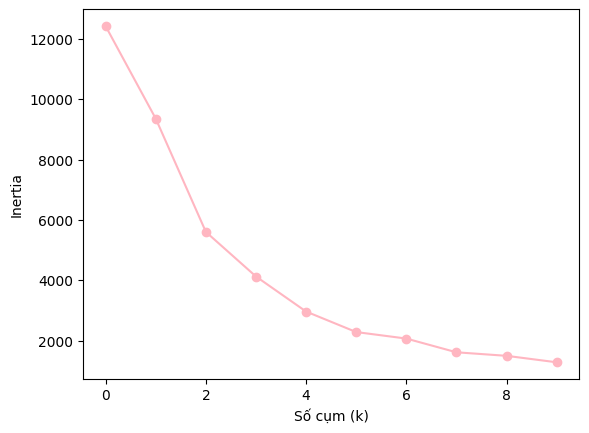

In [32]:
plt.plot(inertia, marker = 'o', color='lightpink')
plt.xlabel("Số cụm (k)")
plt.ylabel("Inertia")
plt.show()

Vẽ biểu đồ elbow tìm k tối ưu 
Từ biểu đồ trên ta thấy có điểm uốn rõ ràng vậy nên cơ  bản ta chọn k = 4


In [33]:
#xây dựng mô hình phân cụm với k = 3
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled)
RFM_data["Clusters"] = (kmeans.labels_ + 1)
RFM_data.head(10)



,Recency,Frequency,Monetary,Clusters
CustomerID,,,,
12347,24,7,2664.14,1
12348,270,3,90.20,2
12349,40,1,710.20,1
12350,332,1,294.40,2
12352,58,7,711.09,1
12353,226,1,29.30,2
12354,254,1,504.39,2
12355,236,1,102.90,2
12356,267,2,715.76,2


In [34]:
sum = RFM_data.groupby(["Clusters"])[["Recency", "Frequency", "Monetary"]].mean()
sum

,Recency,Frequency,Monetary
Clusters,,,
1,65.934016,3.324277,637.045763
2,269.159533,1.495136,233.445769
3,23.500000,143.750000,32216.927500
4,35.003650,17.364964,3878.813431


từ bảng tổng kết trên ta có thể thấy các cụm khách hàng bao gồm 
Cụm 1: nhóm khách hàng mới, nhóm khách hàng này có chi tiêu tương đối, tần xuất cao hơn cụm 2   
-> Sử dụng chương trình khuyến mãi nhẹ hoặc tích điểm để giữ chân họ
Cụm 2: Khách hàng có nguy cơ rời bỏ, họ đã lâu không mua hàng, tuần xuất mua thấp, và chi tiêu ít nhất trong 3 cụm
->  Gửi email marketing, giảm giá đặc biệt để lôi kéo họ quay trở lại
Cụm 3: Nhóm khách hàng vip, tuần xuất mua nhiều, chi tiêu vượt trội 
-> Dùng các chương trình khách hàng VIP, ưu đãi đặc biệt, chăm sóc riêng để giữ chân họ
Cụm 4: Nhóm khách hàng trung bình, tuần xuất mua ổn, chi tiêu cao
-> Dùng chương trình tích điểm, các khuyến mãi tốt để giữ chân họ

chọn k bằng silhouette scorescore

In [35]:
from sklearn.metrics import silhouette_score
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled)
    score = silhouette_score(scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score:.4f}")

Silhouette Score for k=2: 0.5149
Silhouette Score for k=3: 0.5286
Silhouette Score for k=4: 0.5775
Silhouette Score for k=5: 0.3646
Silhouette Score for k=6: 0.4733
Silhouette Score for k=7: 0.4691
Silhouette Score for k=8: 0.4640
Silhouette Score for k=9: 0.4291
Silhouette Score for k=10: 0.3796


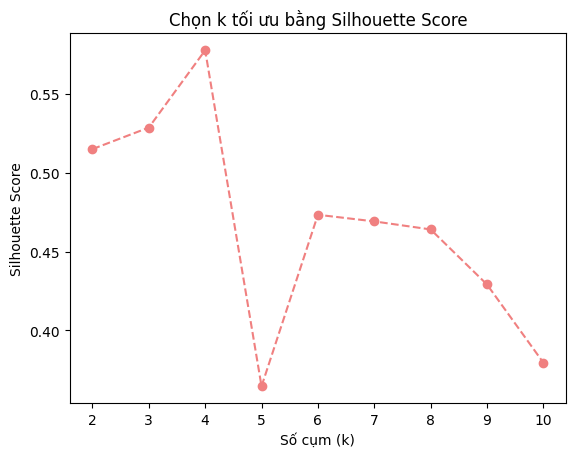

In [36]:
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='dashed', color='lightcoral')
plt.xlabel("Số cụm (k)")
plt.ylabel("Silhouette Score")
plt.title("Chọn k tối ưu bằng Silhouette Score")
plt.show()